In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt

hourly_observations = pd.read_csv("./observations.csv", index_col=0, parse_dates=True)
daily_observations = hourly_observations.resample('D').agg(
    {
        "kwh" : "sum",
        "temp": ["min", "max", "mean"]
    }
)
daily_observations["mean_f"] = daily_observations["temp"]["mean"]*1.8 + 32.
daily_observations["hdd"] = np.where(daily_observations["mean_f"]  <=65., 65. - daily_observations["mean_f"], 0.)


weekly_observations = hourly_observations.resample("W").agg(
        {
        "kwh" : "sum",
        "temp": ["min", "max", "mean"]
    }
)
monthly_observations = hourly_observations.resample('ME').agg(
    {
        "kwh" : "sum",
        "temp": ["min", "max", "mean"]
    }
)

# Weekly HDD
hdd = [None]
for i in range(1, len(weekly_observations.index.to_list())) :
    week_start = weekly_observations.index[i-1]
    week_end = weekly_observations.index[i]
    daily_data = daily_observations[(daily_observations.index > week_start) & (daily_observations.index <= week_end)]
    hdd.append(
            np.sum(np.where(daily_data["mean_f"]  <=65., 65. - daily_data["mean_f"], 0.))
    )
weekly_observations["hdd"] = hdd
weekly_observations["hdd"] = weekly_observations["hdd"].replace(0.0, None)

# Monthly HDD
hdd = []
for date in monthly_observations.index:
    month = date.month
    daily_timestamps = [datetime(date.year, date.month, 1) + timedelta(days=i) for i in range(date.day)]
    data = daily_observations[daily_observations.index.isin(daily_timestamps)]
    hdd.append(
            np.sum(np.where(data["mean_f"]  <=65., 65. - data["mean_f"], 0.))
    )
monthly_observations["hdd"] = hdd

years = range(
    np.min([date.year for date in monthly_observations.index]),
    np.max([date.year for date in monthly_observations.index]) + 1
)


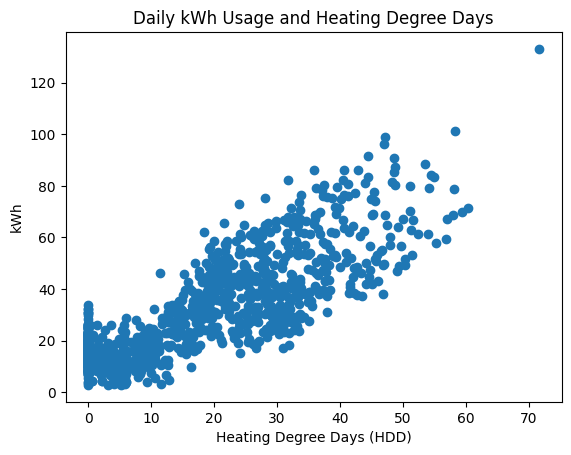

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     2354.
Date:                Fri, 20 Dec 2024   Prob (F-statistic):          3.87e-271
Time:                        09:56:40   Log-Likelihood:                -4049.2
No. Observations:                1059   AIC:                             8102.
Df Residuals:                    1057   BIC:                             8112.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0798      0.022     48.515      0.0

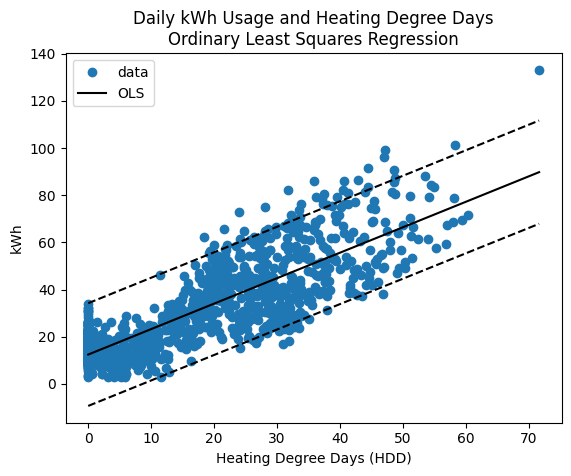

In [2]:
plt.scatter(daily_observations["hdd"], daily_observations["kwh"]["sum"])
plt.xlabel("Heating Degree Days (HDD)")
plt.ylabel("kWh")
plt.title("Daily kWh Usage and Heating Degree Days")
plt.show()

daily_observations["hdd_norm"] = (daily_observations["hdd"]-daily_observations["hdd"].mean())/daily_observations["hdd"].std()
daily_observations["kwh_norm"] = (daily_observations["kwh"]["sum"] - daily_observations["kwh"]["sum"].mean())/daily_observations["kwh"]["sum"].std()

# Ordinary Least Squares
import statsmodels.api as sm

daily_observations_clean: pd.DataFrame = daily_observations.dropna(axis=0)
daily_observations_clean = daily_observations_clean.sort_values(by="hdd", ascending=True)
hdd = daily_observations_clean["hdd"].to_numpy(dtype=float)
kwh = daily_observations_clean["kwh"]["sum"].to_numpy(dtype=float)

A = np.vstack([hdd, np.ones(len(hdd))]).T
model = sm.OLS(kwh, A)
results = model.fit()
print(results.summary())

pred_ols = results.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

plt.plot(hdd, kwh, "o", label="data")
plt.plot(hdd, results.fittedvalues, "k-", label="OLS")
plt.plot(hdd, iv_u, "k--")
plt.plot(hdd, iv_l, "k--")
plt.xlabel("Heating Degree Days (HDD)")
plt.ylabel("kWh")
plt.title("Daily kWh Usage and Heating Degree Days\nOrdinary Least Squares Regression")
plt.legend(loc="best")
plt.show()

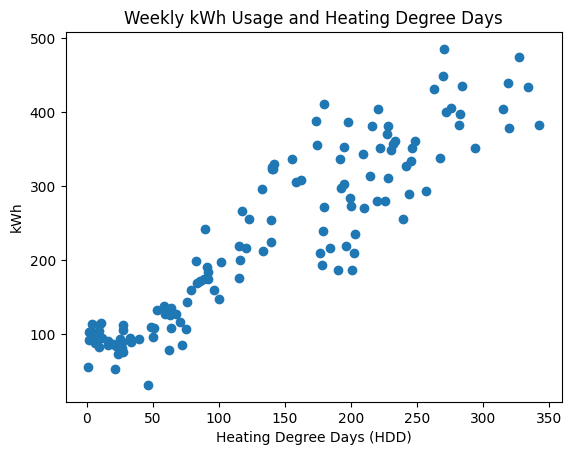

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     661.0
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           2.15e-52
Time:                        09:56:42   Log-Likelihood:                -687.66
No. Observations:                 130   AIC:                             1379.
Df Residuals:                     128   BIC:                             1385.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1419      0.044     25.710      0.0

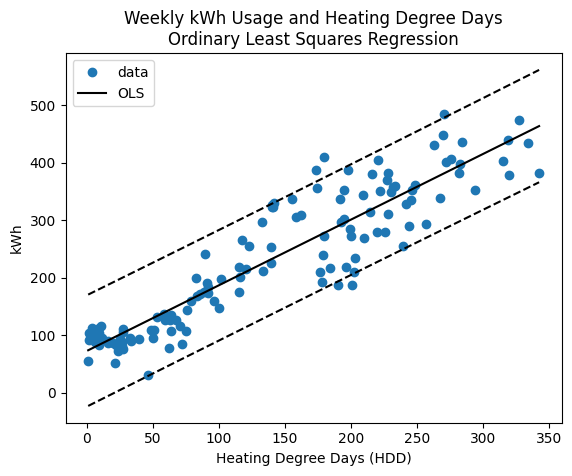

In [3]:
plt.scatter(weekly_observations["hdd"], weekly_observations["kwh"]["sum"])
plt.xlabel("Heating Degree Days (HDD)")
plt.ylabel("kWh")
plt.title("Weekly kWh Usage and Heating Degree Days")
plt.show()

weekly_observations["hdd_norm"] = (weekly_observations["hdd"]-weekly_observations["hdd"].mean())/weekly_observations["hdd"].std()
weekly_observations["kwh_norm"] = (weekly_observations["kwh"]["sum"] - weekly_observations["kwh"]["sum"].mean())/weekly_observations["kwh"]["sum"].std()

# Ordinary Least Squares
import statsmodels.api as sm

weekly_observations_clean: pd.DataFrame = weekly_observations.dropna(axis=0)
weekly_observations_clean = weekly_observations_clean.sort_values(by="hdd", ascending=True)
hdd = weekly_observations_clean["hdd"].to_numpy(dtype=float)
kwh = weekly_observations_clean["kwh"]["sum"].to_numpy(dtype=float)

A = np.vstack([hdd, np.ones(len(hdd))]).T
model = sm.OLS(kwh, A)
results = model.fit()
print(results.summary())

pred_ols = results.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

plt.plot(hdd, kwh, "o", label="data")
plt.plot(hdd, results.fittedvalues, "k-", label="OLS")
plt.plot(hdd, iv_u, "k--")
plt.plot(hdd, iv_l, "k--")
plt.xlabel("Heating Degree Days (HDD)")
plt.ylabel("kWh")
plt.title("Weekly kWh Usage and Heating Degree Days\nOrdinary Least Squares Regression")
plt.legend(loc="best")
plt.show()

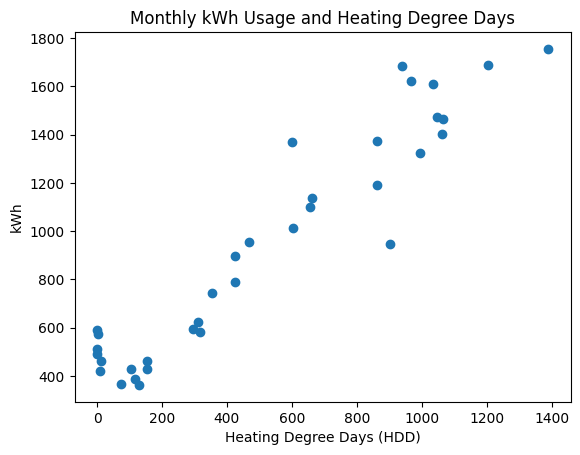

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     303.3
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           3.35e-18
Time:                        09:56:46   Log-Likelihood:                -223.55
No. Observations:                  35   AIC:                             451.1
Df Residuals:                      33   BIC:                             454.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0411      0.060     17.415      0.0

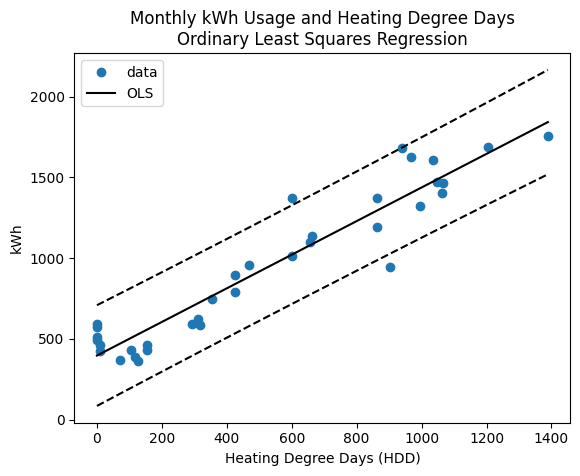

In [4]:
plt.scatter(monthly_observations["hdd"], monthly_observations["kwh"]["sum"])
plt.xlabel("Heating Degree Days (HDD)")
plt.ylabel("kWh")
plt.title("Monthly kWh Usage and Heating Degree Days")
plt.show()

monthly_observations["hdd_norm"] = (monthly_observations["hdd"]-monthly_observations["hdd"].mean())/monthly_observations["hdd"].std()
monthly_observations["kwh_norm"] = (monthly_observations["kwh"]["sum"] - monthly_observations["kwh"]["sum"].mean())/monthly_observations["kwh"]["sum"].std()

# Ordinary Least Squares
import statsmodels.api as sm

monthly_observations_clean: pd.DataFrame = monthly_observations.dropna(axis=0)
monthly_observations_clean = monthly_observations_clean.sort_values(by="hdd", ascending=True)
hdd = monthly_observations_clean["hdd"].to_numpy(dtype=float)
kwh = monthly_observations_clean["kwh"]["sum"].to_numpy(dtype=float)

A = np.vstack([hdd, np.ones(len(hdd))]).T
model = sm.OLS(kwh, A)
results = model.fit()
print(results.summary())

pred_ols = results.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

plt.plot(hdd, kwh, "o", label="data")
plt.plot(hdd, results.fittedvalues, "k-", label="OLS")
plt.plot(hdd, iv_u, "k--")
plt.plot(hdd, iv_l, "k--")
plt.xlabel("Heating Degree Days (HDD)")
plt.ylabel("kWh")
plt.title("Monthly kWh Usage and Heating Degree Days\nOrdinary Least Squares Regression")
plt.legend(loc="best")
plt.show()

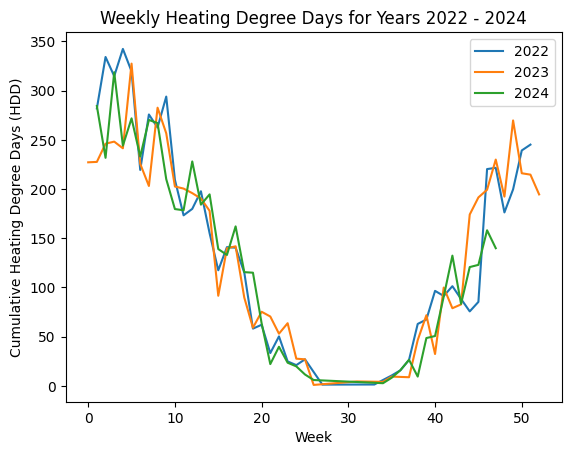

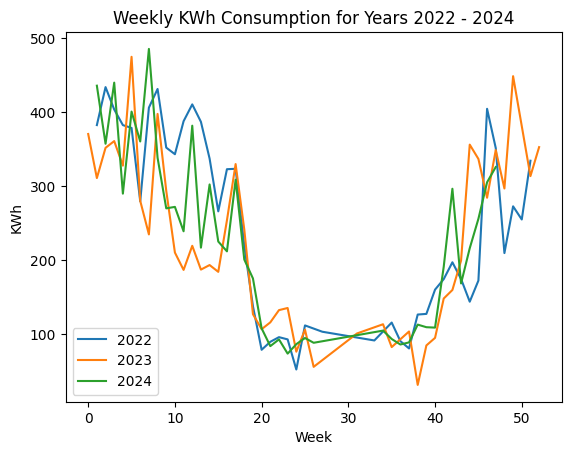

In [5]:
# Weekly data
annualized_data = []
for year in years:
    df = weekly_observations[weekly_observations.index.year == year]
    df = df[df['hdd'].notna()]
    annualized_data.append(
        df
    )
    
def weekly_timstamps_to_week_num(data):
    return [int((timestamp - datetime(timestamp.year-1, 12, 31)).days /7.) for timestamp in data.index]

for i, data in enumerate(annualized_data):
    weeks = weekly_timstamps_to_week_num(data)
    plt.plot(weeks, data["hdd"], label=years[i])
    plt.xlabel("Week")
    plt.ylabel("Cumulative Heating Degree Days (HDD)")
    plt.title(f"Weekly Heating Degree Days for Years {years[0]} - {years[-1]}")
    plt.legend()    
plt.show()

for i, data in enumerate(annualized_data):
    weeks = weekly_timstamps_to_week_num(data)
    plt.plot(weeks, data["kwh"], label=years[i])
    plt.xlabel("Week")
    plt.ylabel("KWh")
    plt.title(f"Weekly KWh Consumption for Years {years[0]} - {years[-1]}")
    plt.legend()
plt.show()


                                                        p  r_squared  \
degree                                                                 
2                 [0.387100572296026, -22.72343988329386]   0.805062   
3       [0.009117403697494593, -0.30206723278146336, -...   0.868697   
4       [-0.0005946078316039725, 0.07115426585384639, ...   0.914217   
5       [-6.1204143016761745e-06, 0.000189101995321660...   0.915030   
6       [-7.429613132280088e-07, 0.0001101541179375116...   0.917222   
7       [-1.274239458038126e-08, 1.5548178317074137e-0...   0.917321   
8       [-4.6027987225025216e-09, 9.438318322220613e-0...   0.919887   
9       [-1.2564658590482714e-11, -1.677511278685671e-...   0.919890   

                mse       rmse  
degree                          
2       1777.310803  42.158164  
3       1197.126913  34.599522  
4        782.108859  27.966209  
5        774.697578  27.833390  
6        754.708203  27.471953  
7        753.810069  27.455602  
8        730.41

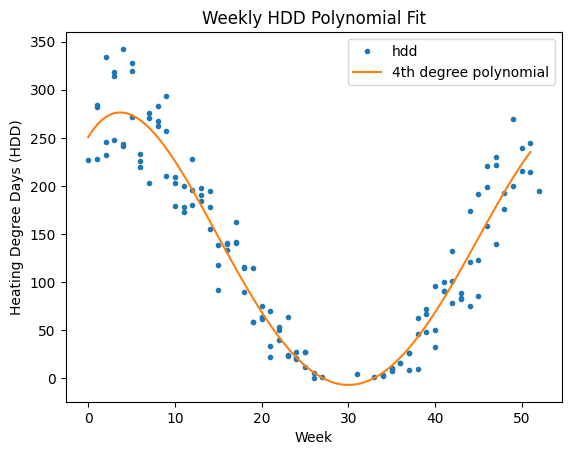

In [6]:
# Weekly HDD

# Consolidate data into single dataframe, stripping out year
x = np.concatenate([weekly_timstamps_to_week_num(data) for data in annualized_data], axis= 0).astype(float)
weekly_hdd = np.concatenate([data["hdd"].to_numpy() for data in annualized_data], axis=0).astype(float)


# We can figure out which fit is the best with highest r_squared and lowest root mean squared error (rmse)
fit_data = []
for deg in range(2,10):

    # Polynomial fit for hdd
    z = np.polyfit(x, weekly_hdd, deg)
    p = np.poly1d(z)

    # Calculate fit statistics
    correlation_matrix = np.corrcoef(weekly_hdd, p(x))
    r_squared = correlation_matrix[0, 1] ** 2
    mse = np.mean((weekly_hdd - p(x))**2)
    rmse = np.sqrt(mse)
    fit_data.append([deg, p, r_squared, mse, rmse])

fit = pd.DataFrame(data = fit_data, columns= ["degree", "p", "r_squared", "mse", "rmse"])
fit = fit.set_index('degree')
print(fit)
fit.to_csv("weekly_poly.csv")

# We can see that after degree 4, the returns are diminishing
p = fit.loc[4]["p"]
print(f'4th deg poly = {p}')
xp = np.linspace(0, 51, 100)
plt.plot(x, weekly_hdd, '.', label="hdd")
plt.plot(xp, p(xp), '-', label="4th degree polynomial")
plt.xlabel("Week")
plt.ylabel("Heating Degree Days (HDD)")
plt.title(f"Weekly HDD Polynomial Fit")
plt.legend()
plt.show()


[382.807 434.181 403.925 382.779 379.012 279.691 406.39  431.659 352.35
 343.426 388.055 410.829 387.218 337.522 266.14  323.152 323.702 219.671
 137.77   78.924  89.721  96.017  92.983  52.276 111.888 103.339  91.542
 115.745  90.667  80.725 126.59  127.47  160.277 174.476 197.279 174.639
 143.968 172.544 404.831 351.764 209.73  272.947 255.156 334.643 370.755
 311.171 352.059 361.17  327.952 475.162 280.378 235.    397.936 294.067
 210.402 186.948 219.554 187.371 193.528 184.349 253.995 330.098 241.626
 127.058 106.787 116.009 132.568 135.441  76.361 106.193  55.854 101.024
 113.461  82.579 103.701  31.41   84.81   95.054 148.262 159.797 199.57
 356.391 337.057 284.531 349.047 297.072 448.964 381.502 313.808 353.01
 436.107 357.591 440.233 290.103 401.094 360.641 485.829 338.66  270.21
 272.188 239.187 382.015 217.072 302.511 225.35  212.061 308.951 201.025
 175.376 107.896  83.872  92.978  73.716  86.522  94.856  88.399 104.859
  93.518  86.069  88.919 112.967 109.473 108.92  191.16

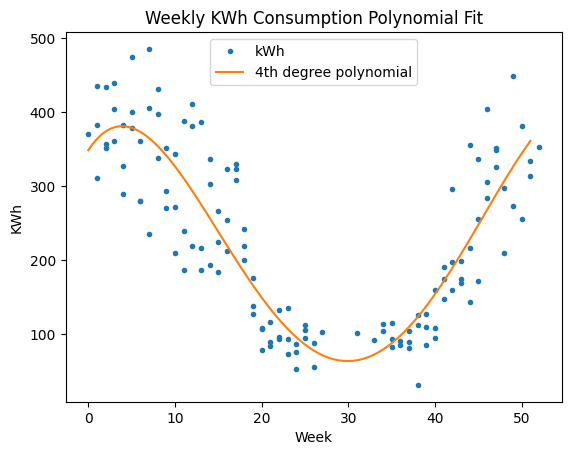

In [36]:
# Weekly KWH

# Consolidate data into single dataframe, stripping out year
x = np.concatenate([weekly_timstamps_to_week_num(data) for data in annualized_data], axis= 0).astype(float)
weekly_kwh = np.concatenate([data["kwh"]["sum"].to_numpy() for data in annualized_data], axis=0).astype(float)

# We can figure out which fit is the best with highest r_squared and lowest root mean squared error (rmse)
fit_data = []
for deg in range(2,10):

    # Polynomial fit for kwh
    z = np.polyfit(x, weekly_kwh, deg)
    p = np.poly1d(z)

    # Calculate fit statistics
    correlation_matrix = np.corrcoef(weekly_kwh, p(x))
    r_squared = correlation_matrix[0, 1] ** 2
    mse = np.mean((weekly_kwh - p(x))**2)
    rmse = np.sqrt(mse)
    fit_data.append([deg, p, r_squared, mse, rmse])

fit = pd.DataFrame(data = fit_data, columns= ["degree", "p", "r_squared", "mse", "rmse"])
fit = fit.set_index('degree')
print(fit)

# We can see that after degree 4, the returns are diminishing
p = fit.loc[4]["p"]
xp = np.linspace(0, 51, 100)
plt.plot(x, weekly_kwh, '.', label="kWh")
plt.plot(xp, p(xp), '-', label="4th degree polynomial")
plt.xlabel("Week")
plt.ylabel("KWh")
plt.title(f"Weekly KWh Consumption Polynomial Fit")
plt.legend()
plt.show()


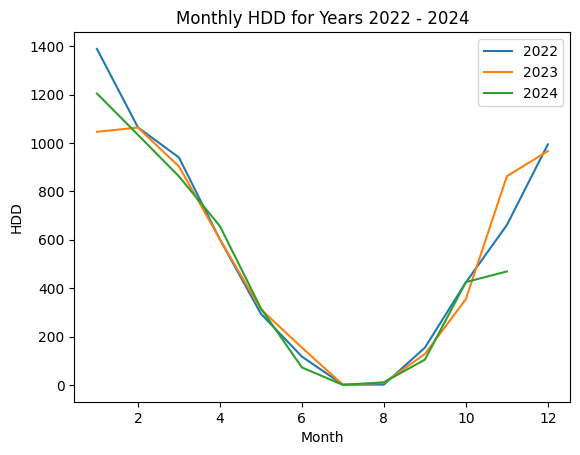

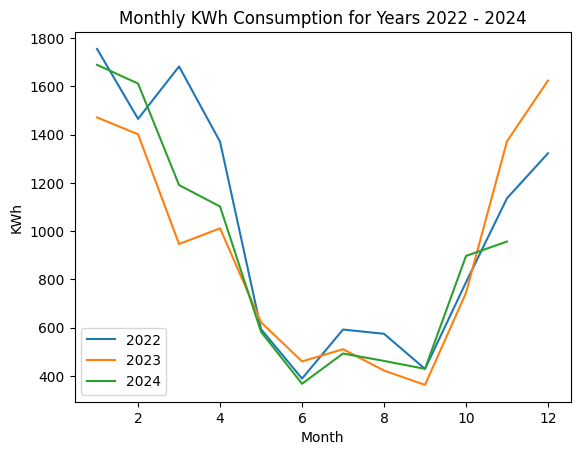

In [70]:
annualized_data = []
annualized_data = []
for year in years:
    annualized_data.append(
        monthly_observations[monthly_observations.index.year == year]
    )

# Plot HDD
for i, data in enumerate(annualized_data):
    plt.plot(range(1,len(data.index) + 1), data["hdd"], label=years[i])
    plt.xlabel("Month")
    plt.ylabel("HDD")
    plt.title(f"Monthly HDD for Years {years[0]} - {years[-1]}")
    plt.legend()
plt.show()

# Plot KWh
for i, data in enumerate(annualized_data):
    plt.plot(range(1,len(data.index) + 1), data["kwh"], label=years[i])
    plt.xlabel("Month")
    plt.ylabel("KWh")
    plt.title(f"Monthly KWh Consumption for Years {years[0]} - {years[-1]}")
    plt.legend()
plt.show()

                                                        p  r_squared  \
degree                                                                 
2                 [34.38120638691127, -493.5437403547648]   0.900203   
3       [3.112044178593816, -25.441134452664937, -174....   0.950352   
4       [-0.7172595673022245, 21.60608988452381, -183....   0.972607   
5       [-0.045397880123000105, 0.752470889647902, 4.2...   0.973297   
6       [0.01952994347652232, -0.8059921252330476, 12....   0.974182   
7       [-0.004382886621706576, 0.21887216015806624, -...   0.974451   
8       [0.0034254759920050574, -0.18249269847741242, ...   0.975276   
9       [0.0005767690620710465, -0.030315089255256333,...   0.975369   
10      [-4.7870088812926896e-05, 0.003688321103958239...   0.975371   

                 mse        rmse  
degree                            
2       17484.848481  132.230286  
3        8698.579919   93.266178  
4        4799.354183   69.277371  
5        4678.484528   68.399448

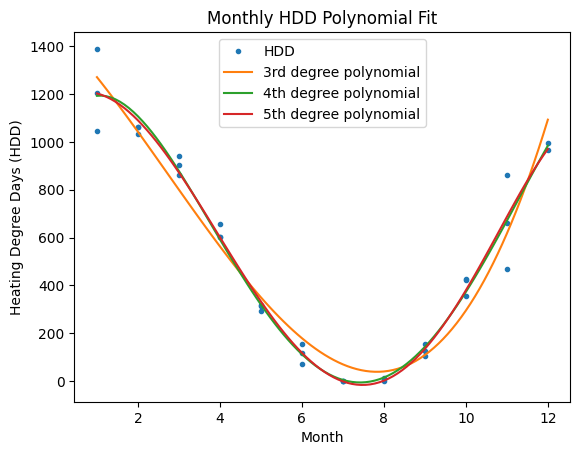

In [71]:
# Monthly HDD

# Consolidate data into single dataframe, stripping out year
x = np.concatenate([data.index.month for data in annualized_data], axis= 0).astype(float)

monthly_hdd = np.concatenate([data["hdd"].to_numpy() for data in annualized_data], axis=0).astype(float)

# We can figure out which fit is the best with highest r_squared and lowest root mean squared error (rmse)
fit_data = []
for deg in range(2,11):

    # Polynomial fit for kwh
    z = np.polyfit(x, monthly_hdd, deg)
    p = np.poly1d(z)

    # Calculate fit statistics
    correlation_matrix = np.corrcoef(monthly_hdd, p(x))
    r_squared = correlation_matrix[0, 1] ** 2
    mse = np.mean((monthly_hdd - p(x))**2)
    rmse = np.sqrt(mse)
    fit_data.append([deg, p, r_squared, mse, rmse])

fit = pd.DataFrame(data = fit_data, columns= ["degree", "p", "r_squared", "mse", "rmse"])
fit = fit.set_index('degree')
fit.to_csv("monthly polyfit")

print(fit)

# 5th Degree
p = fit.loc[5]["p"]
xp = np.linspace(1, 12, 100)
plt.plot(x, monthly_hdd, '.', label="HDD")
plt.plot(xp, fit.loc[3]["p"](xp), '-', label="3rd degree polynomial")
plt.plot(xp, fit.loc[4]["p"](xp), '-', label="4th degree polynomial")
plt.plot(xp, fit.loc[5]["p"](xp), '-', label="5th degree polynomial")
plt.xlabel("Month")
plt.ylabel("Heating Degree Days (HDD)")
plt.title(f"Monthly HDD Polynomial Fit")
plt.legend()
plt.show()

In [63]:
# Monthly KWH

# Consolidate data into single dataframe, stripping out year
x = np.concatenate([data.index.month for data in annualized_data], axis= 0).astype(float)

monthly_kwh = np.concatenate([data["kwh"]["sum"].to_numpy() for data in annualized_data], axis=0).astype(float)

# We can figure out which fit is the best with highest r_squared and lowest root mean squared error (rmse)
fit_data = []
for deg in range(2,11):

    # Polynomial fit for kwh
    z = np.polyfit(x, monthly_kwh, deg)
    p = np.poly1d(z)

    # Calculate fit statistics
    correlation_matrix = np.corrcoef(monthly_kwh, p(x))
    r_squared = correlation_matrix[0, 1] ** 2
    mse = np.mean((monthly_kwh - p(x))**2)
    rmse = np.sqrt(mse)
    fit_data.append([deg, p.tolist(), r_squared, mse, rmse])

fit = pd.DataFrame(data = fit_data, columns= ["degree", "p", "r_squared", "mse", "rmse"])
fit = fit.set_index('degree')

# 5th Degree
p = fit.loc[5]["p"]
xp = np.linspace(1, 12, 100)
plt.plot(x, monthly_kwh, '.', label="kWh")
plt.plot(xp, fit.loc[3]["p"](xp), '-', label="3rd degree polynomial")
plt.plot(xp, fit.loc[5]["p"](xp), '-', label="5th degree polynomial")
plt.plot(xp, fit.loc[7]["p"](xp), '-', label="7th degree polynomial")
plt.xlabel("Month")
plt.ylabel("KWh")
plt.title(f"Monthly KWh Consumption Polynomial Fit")
plt.legend()
plt.show()


AttributeError: 'poly1d' object has no attribute 'tolist'